<a href="https://colab.research.google.com/github/Sahith-Rao/complaint-classifier-django/blob/main/AL_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-khwnvs3c
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-khwnvs3c
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adhamelkomy/bank-customer-complaint-analysis
License(s): CC0-1.0
bank-customer-complaint-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bank-customer-complaint-analysis.zip
replace Bank Customer Complaint Analysis for Efficient Dispute Resolution.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Bank Customer Complaint Analysis for Efficient Dispute Resolution.ipynb  
replace complaints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: complaints.csv          
replace complaints_report_20240226_183305.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: complaints_report_20240226_183305.txt  
replace final_dataframe (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: final_dataframe (1).csv  


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing text data...


100%|██████████| 162411/162411 [05:45<00:00, 469.70it/s]


Preprocessing completed.

Initial training set: 25985 samples
Pool for active learning: 103943 samples
Test set: 32483 samples

Starting hyperparameter tuning...

Best Random Forest parameters:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__class_weight': 'balanced'}

Initial accuracy: 0.8584
Running exactly 50 iterations with 500 samples per query
Iteration 1/50 | Added 500 samples | Total samples: 26485 | Accuracy: 0.8609
Iteration 2/50 | Added 500 samples | Total samples: 26985 | Accuracy: 0.8620
Iteration 3/50 | Added 500 samples | Total samples: 27485 | Accuracy: 0.8625
Iteration 4/50 | Added 500 samples | Total samples: 27985 | Accuracy: 0.8641
Iteration 5/50 | Added 500 samples | Total samples: 28485 | Accuracy: 0.8653
Iteration 6/50 | Added 500 samples | Total samples: 28985 | Accuracy: 0.8650
Iteration 7/50 | Added 500 samples | Total samples: 29485 | Accuracy: 0.8679
Iteratio

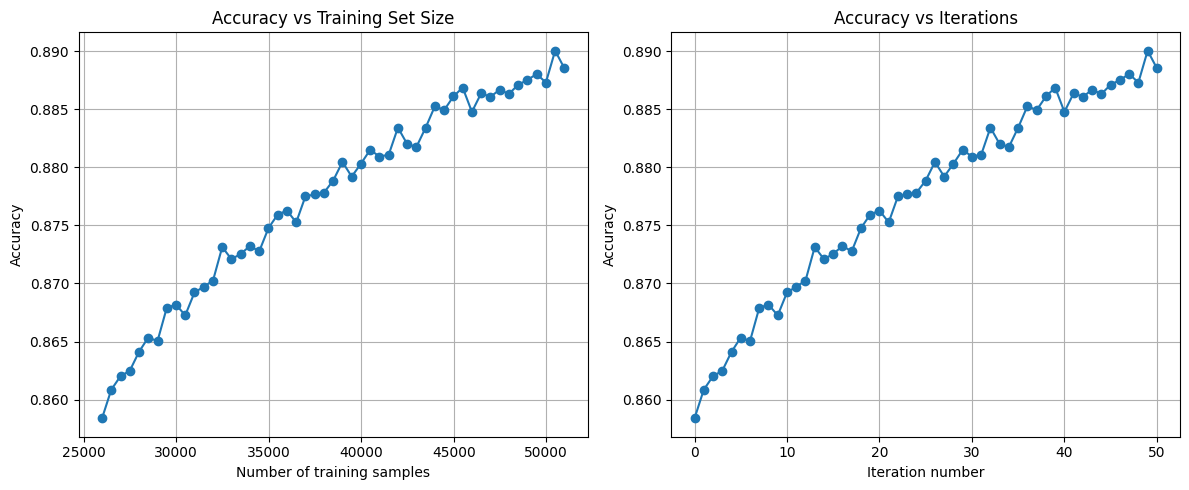


Final Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.77      0.78      3132
           2       0.85      0.88      0.87      2683
           3       0.92      0.95      0.94     18283
           4       0.86      0.83      0.84      3770
           5       0.84      0.77      0.81      4615

    accuracy                           0.89     32483
   macro avg       0.86      0.84      0.85     32483
weighted avg       0.89      0.89      0.89     32483



In [2]:
!pip install git+https://github.com/modAL-python/modAL.git
!pip install tqdm
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from google.colab import files
from sklearn.metrics import accuracy_score, classification_report
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import nltk
from tqdm import tqdm
tqdm.pandas()

# Upload and load dataset
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adhamelkomy/bank-customer-complaint-analysis
!unzip bank-customer-complaint-analysis.zip

import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import nltk
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

# Download NLTK data if needed
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

tqdm.pandas()

# Load and preprocess data
df = pd.read_csv("complaints.csv")
df.rename(columns={'Unnamed: 0': 'Complaint_No'}, inplace=True)

# Convert product categories to numerical labels
df["product"] = df["product"].replace({
    "credit_card": "1",
    "retail_banking": "2",
    "credit_reporting": "3",
    "mortgages_and_loans": "4",
    "debt_collection": "5"
}, regex=False)

# Clean data
df = df.dropna()
df["narrative"] = df["narrative"].str.lower()

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    try:
        if not isinstance(text, str):
            return ""
        text = text.translate(str.maketrans('', '', string.punctuation))
        try:
            words = word_tokenize(text)
        except:
            words = text.split()
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        words = [lemmatizer.lemmatize(word) for word in words]
        words = [stemmer.stem(word) for word in words]
        return " ".join(words)
    except Exception as e:
        print(f"Error processing text: {str(e)[:100]}...")
        return ""

print("Preprocessing text data...")
df["narrative"] = df["narrative"].progress_apply(preprocess_text)
print("Preprocessing completed.")

# Prepare features and labels
X = df['narrative'].values
y = df["product"].values

# Split into initial training pool and test set
X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

print(f"\nInitial training set: {len(X_train)} samples")
print(f"Pool for active learning: {len(X_pool)} samples")
print(f"Test set: {len(X_test)} samples")

# Create a pipeline with TF-IDF and feature selection
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('feature_selection', SelectKBest(chi2, k=3000)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced']
}

X_tune, _, y_tune, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)
rf_search = RandomizedSearchCV(
    pipeline,
    rf_params,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

print("\nStarting hyperparameter tuning...")
rf_search.fit(X_tune, y_tune)
best_pipeline = rf_search.best_estimator_

print("\nBest Random Forest parameters:")
print(rf_search.best_params_)

# Query Strategy (500 samples per query)
def query_strategy_500(classifier, X_pool):
    batch_size = min(500, len(X_pool))
    probas = classifier.predict_proba(X_pool)
    if probas.shape[1] >= 2:
        top_probs = -np.partition(-probas, 2, axis=1)[:, :2]
        margins = top_probs[:, 0] - top_probs[:, 1]
        query_idx = np.argpartition(margins, batch_size)[:batch_size]
    else:
        query_idx = np.random.choice(len(X_pool), size=batch_size, replace=False)
    return query_idx, X_pool[query_idx]

# Initialize ActiveLearner with tuned pipeline
learner = ActiveLearner(
    estimator=best_pipeline,
    query_strategy=query_strategy_500,
    X_training=X_train,  # RAW TEXT
    y_training=y_train
)

def evaluate_model(learner, X, y):
    predictions = learner.predict(X)
    return accuracy_score(y, predictions)

# Active learning with 50 iterations (changed from 20 to 50)
max_queries = 50  # CHANGED FROM 20 TO 50
performance_history = [evaluate_model(learner, X_test, y_test)]
samples_added_history = [len(X_train)]

print(f"\nInitial accuracy: {performance_history[0]:.4f}")
print(f"Running exactly {max_queries} iterations with 500 samples per query")

for query_num in range(1, max_queries + 1):
    if len(X_pool) == 0:
        print("\nPool exhausted - no more samples available")
        break

    # Query for 500 most uncertain instances
    query_idx, _ = learner.query(X_pool)
    actual_batch_size = len(query_idx)

    learner.teach(X=X_pool[query_idx], y=y_pool[query_idx])

    mask = np.ones(len(X_pool), dtype=bool)
    mask[query_idx] = False
    X_pool = X_pool[mask]
    y_pool = y_pool[mask]

    current_acc = evaluate_model(learner, X_test, y_test)
    performance_history.append(current_acc)
    samples_added_history.append(samples_added_history[-1] + actual_batch_size)

    print(f"Iteration {query_num}/{max_queries} | "
          f"Added {actual_batch_size} samples | "
          f"Total samples: {samples_added_history[-1]} | "
          f"Accuracy: {current_acc:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(samples_added_history, performance_history, marker='o')
plt.title('Accuracy vs Training Set Size')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(performance_history)), performance_history, marker='o')
plt.title('Accuracy vs Iterations')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
final_predictions = learner.predict(X_test)
print("\nFinal Classification Report:")
print(classification_report(y_test, final_predictions))

In [ ]:
# Save the trained pipeline
joblib.dump(learner.estimator, 'complaint_classifier_pipeline.joblib')

# Save the category mapping
category_mapping = {
    "1": "credit_card",
    "2": "retail_banking",
    "3": "credit_reporting",
    "4": "mortgages_and_loans",
    "5": "debt_collection"
}
joblib.dump(category_mapping, 'category_mapping.joblib')